# 異常検知　最終発表資料（2021/06/01 1）
# 目的

2000-2020年までの南極（昭和基地）の気象データを用いて異常度を測る。

# 内容
- 気象データからどの年が異常度の閾値が超えるのかを検証する。
- 異常と判定された数をそれぞれの月ごとに数えて、年単位で異常の数の多い少ないで考える。
- 明確に異常、正常の分離をするためのラベルはないと考えられるので、正規分布による異常検知では、閾値はカイ2乗の5%で判別してみる。
- 1次元正規分布では平均気温で見てみる。
- アイソレーションフォレストではscikit-learnを用いて、異常の判定をし、数を数えてみる。
- 時系列データとしてARモデルで平均気温の異常度を見てみる
- 多変数としてはガウス型グラフィカルモデルを用いて、外れ値検出問題として検討する。

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm
from matplotlib import ticker
import matplotlib.dates as mdates

import datetime as dt
import calendar

import scipy
import scipy.stats as stats


import statsmodels.api as sm
import changefinder

In [2]:
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'IPAexGothic'

# データの読み込み
昭和基地のデータを読み込む

In [3]:
# データの年の範囲の指定
data_period = range(2000,2021)
#data_period = range(1980,2021)

In [4]:
def get_data_file(data_period):
    data_file = [str(year) + ".csv" for year in data_period]

    df = None
    for datafile_name in data_file:
        df_tmp = pd.read_csv('Data/'+datafile_name, header=4,encoding = "shift-jis")
        if df is None:
            df = df_tmp
        else:
            df = pd.concat([df, df_tmp],axis=0)
    # nanを前日の値から埋める。
    df.fillna(method = 'ffill',inplace=True)
    return df

df = get_data_file(data_period)

In [5]:
def make_df_tpl(df):
    
    # 定義し直し
    # 日付の文字列から日付型への変換
    df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], format='%Y/%m/%d')

    # 使えそう数値項目のみの抜き出し
    #df_tpl = df.iloc[:,[0,1,4,9,25,29,32,43,46,53,63,66,69,74,77,80,87]] 
    # 0:'日付', 1:'平均気温', 4:'最高気温', 9:'最低気温',25:'日照時間',29:'合計全天日射量(MJ/㎡)',
    # 32:'最深積雪(cm)',43:'平均風速',46:'最大風速',53:'最大瞬間風速',63:'平均湿度',66:'平均蒸気圧',
    # 69:'最小相対湿度',74:'平均現地気圧',77:'平均海面気圧',78:'最低海面気圧',87:'平均雲量(10分比)'

    # 日照時間はエラーが出る場合があるので、最初に外しておく。
    df_tpl = df.iloc[:,[0,1,4,9,29,32,43,46,53,63,66,69,74,77,80,87]] 

    # ヘッダの構成
    #columns = ['日付', '平均気温', '最高気温', '最低気温','日照時間','合計全天日照量','最深積雪','平均風速','最大風速','最大瞬間風速','平均湿度','平均蒸気圧','最小相対湿度','平均現地気圧','平均海面気圧','最低海面気圧','平均雲量']
    columns = ['日付', '平均気温', '最高気温', '最低気温','合計全天日照量','最深積雪','平均風速','最大風速','最大瞬間風速','平均湿度','平均蒸気圧','最小相対湿度','平均現地気圧','平均海面気圧','最低海面気圧','平均雲量']
    df_tpl.columns = columns
    return df_tpl, columns

df_tpl, columns = make_df_tpl(df)

In [6]:
df_tpl.head()

,日付,平均気温,最高気温,最低気温,合計全天日照量,最深積雪,平均風速,最大風速,最大瞬間風速,平均湿度,平均蒸気圧,最小相対湿度,平均現地気圧,平均海面気圧,最低海面気圧,平均雲量
0,2000-01-01,-3.0,0.4,-5.3,35.6,25.0,2.6,4.9,7.1,67.0,3.3,47.0,983.1,985.7,0.0,5.3
1,2000-01-02,-5.3,-3.9,-8.2,32.0,22.0,3.3,6.8,9.2,78.0,3.2,61.0,977.9,980.5,0.0,6.0
2,2000-01-03,-3.6,-0.9,-5.3,32.7,19.0,3.1,5.8,8.8,78.0,3.6,64.0,972.6,975.1,0.0,5.8
3,2000-01-04,-3.4,-0.3,-7.2,34.7,19.0,2.5,5.1,7.0,63.0,3.0,50.0,975.4,978.0,0.0,2.3
4,2000-01-05,-1.9,1.0,-5.3,24.8,18.0,2.5,7.0,8.8,67.0,3.6,55.0,982.0,984.6,0.0,10.0


In [7]:
def make_data_hash(df_tpl, data_period):
    # 年、月ごとに2次元連想配列を作成する。
    data_hash = {}
    for year in data_period:
        df_month = {}
        for month in range(1,13):
            df_month[month] = df_tpl[(df_tpl['日付'] >= dt.datetime(year,month,1)) & (df_tpl['日付'] <=dt.datetime(year,month,calendar.monthrange(year, month)[1])) ]
        data_hash[year] = df_month
        
    return data_hash

data_hash = make_data_hash(df_tpl, data_period)

In [8]:
data_hash[2000][1].head()

,日付,平均気温,最高気温,最低気温,合計全天日照量,最深積雪,平均風速,最大風速,最大瞬間風速,平均湿度,平均蒸気圧,最小相対湿度,平均現地気圧,平均海面気圧,最低海面気圧,平均雲量
0,2000-01-01,-3.0,0.4,-5.3,35.6,25.0,2.6,4.9,7.1,67.0,3.3,47.0,983.1,985.7,0.0,5.3
1,2000-01-02,-5.3,-3.9,-8.2,32.0,22.0,3.3,6.8,9.2,78.0,3.2,61.0,977.9,980.5,0.0,6.0
2,2000-01-03,-3.6,-0.9,-5.3,32.7,19.0,3.1,5.8,8.8,78.0,3.6,64.0,972.6,975.1,0.0,5.8
3,2000-01-04,-3.4,-0.3,-7.2,34.7,19.0,2.5,5.1,7.0,63.0,3.0,50.0,975.4,978.0,0.0,2.3
4,2000-01-05,-1.9,1.0,-5.3,24.8,18.0,2.5,7.0,8.8,67.0,3.6,55.0,982.0,984.6,0.0,10.0


# 月ごとの内容を一旦参照
1次元データとして平均気温を参照する。

In [9]:
# 各項目で月ごとにまとめ直し、年で表にする関数
def make_data_table_hash(data_hash, data_label, data_period):
    data_table_hash = {}
    for month in range(1,13):
        df_tmp = None
        for year in data_period:
            if df_tmp is None:
                df_tmp = data_hash[year][month][data_label]
            else:
                df_tmp = pd.concat((df_tmp,data_hash[year][month][data_label]),axis=1)
        df_tmp.columns = [y for y in data_period]
        data_table_hash[month] = df_tmp

    return data_table_hash

In [10]:
# 月ごとの気温のデータフレームを作成する。（行は年、列は月）
data_label = '平均気温'
#data_label = '平均湿度'
#data_label = '最高気温'
#data_label = '最低気温'
#data_label = '最深積雪'
#data_lable = '平均雲量'

data_tpl_mean_hash = make_data_table_hash(data_hash, data_label, data_period)

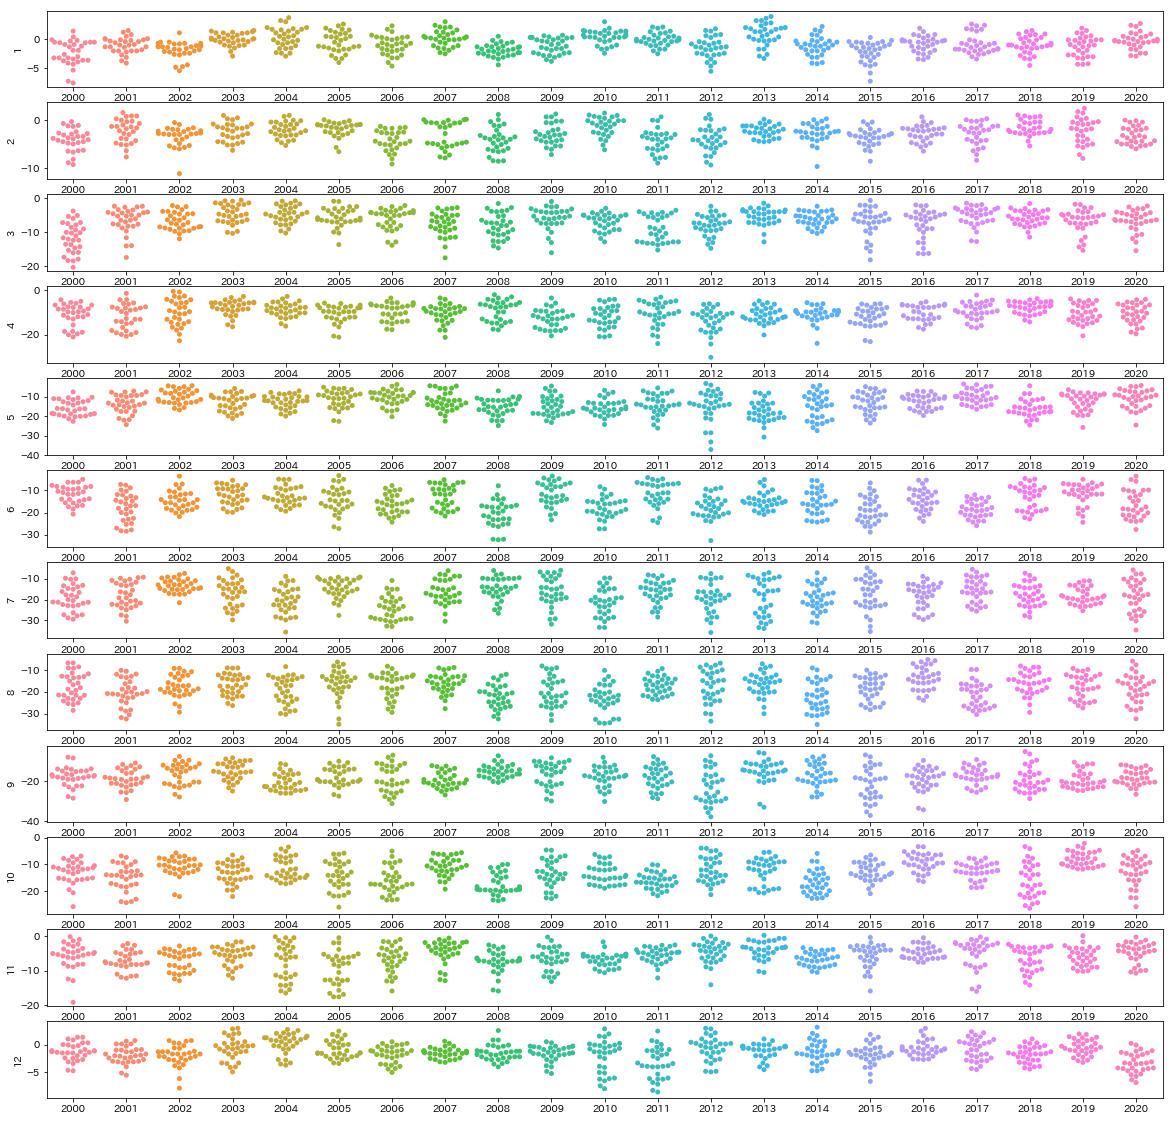

In [11]:
# 各月の平均気温の年ごとの変化
fig,ax = plt.subplots(12,1,figsize=(20,20))
for i in range(0,12): 
    figure = sns.swarmplot(data=data_tpl_mean_hash[i+1], ax=ax[i])
    figure.set(ylabel=str(i+1))

## 年にかかわらず、月ごとのデータでまとめ直す。
各年における月ごとの比較をするため。

In [12]:
def make_month_set_hash(data_hash, data_period):
    month_set_hash = {}
    for month in range(1,13):
        month_set = None
        for year in data_period:
            tmp = data_hash[year][month]
            if month_set is None:
                month_set = tmp
            else:
                month_set = pd.concat([month_set,tmp],axis=0)
        month_set = month_set.reset_index(drop=True) # indexの振り直し
        month_set_hash[month] = month_set
    return month_set_hash

In [13]:
month_set_hash = make_month_set_hash(data_hash, data_period)

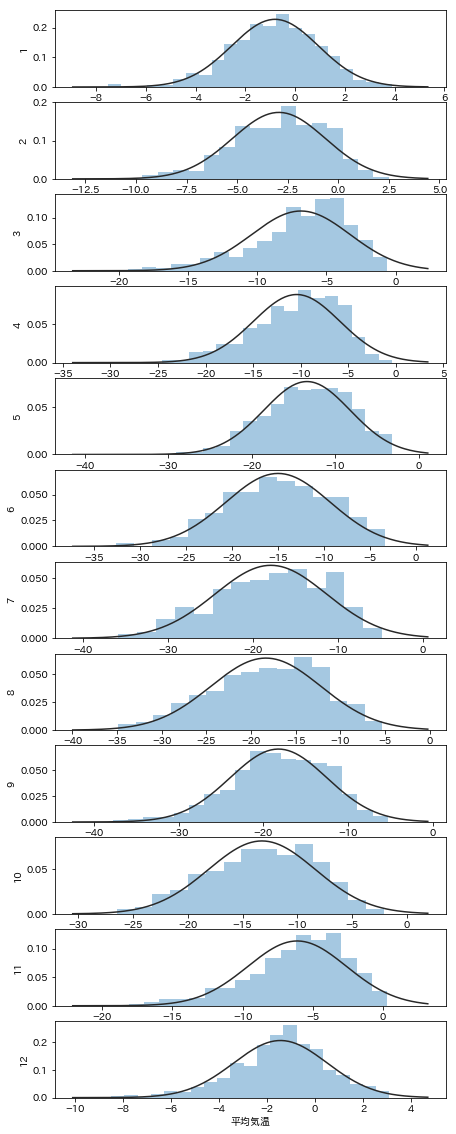

In [14]:
# 平均気温の分布をみる。
fig,ax = plt.subplots(12,1,figsize=(7,20))
for i in range(0,12):
    month = i + 1
    figure = sns.distplot(month_set_hash[month][data_label],fit=norm,kde=False,ax=ax[i])
    ax[i].set(ylabel=str(month))
plt.show()

# 対象の設定
平均気温を正規分布及び時系列の対象として考える。

In [15]:
target = '平均気温'

# 1次元の正規分布としての異常度の算出
月ごとの平均気温は正規分布に従うと仮定して、異常度を算出する。

In [16]:
def get_musigma(month_set_hash, target):
    # 平均、分散の算出
    muhat = {}
    sigmahat = {}
    for month in range(1,13):
        muhat[month] =month_set_hash[month][target].mean()
        sigmahat[month] = month_set_hash[month][target].std(ddof=0)
    return muhat, sigmahat

muhat,sigmahat = get_musigma(month_set_hash, target)

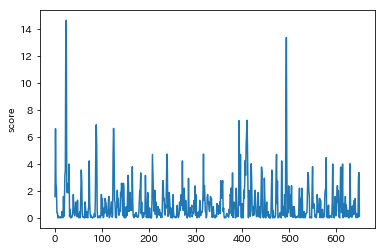

In [17]:
# 定義し直した異常度を用いる場合
def calc_score(x, mu, sigma):
    return ((x-mu)/sigma)**2

def get_ascore(month_set_hash, muhat, sigmahat, target):
    ascore = {}
    for month in range(1,13):
        ascore[month] = calc_score(month_set_hash[month][target], muhat[month], sigmahat[month])
    return ascore

ascore = get_ascore(month_set_hash, muhat, sigmahat, target)

# 1月の異常度の一覧
# 1月のみ表示
plt.plot(ascore[1])
plt.xlabel("")
plt.ylabel("score")
plt.show()

異常データとしてのサンプルはないものとすると、何らかの基準が必要なので、とりあえず5%を閾値とする。

In [18]:
# 閾値を5%にする場合
a_th = stats.chi2.ppf(0.95, df=1)
a_th

3.841458820694124

In [19]:
def get_abnorm_set_hash(month_set_hash, ascore, data_period, a_th):
    # 月で閾値を超えたデータを、年ごとでカウントする。
    date_index = [dt.datetime.strptime(str(i) + '-12-31', '%Y-%m-%d') for i in data_period]
    abnorm_set_hash = {}
    for month in range(1,13):
        abnorm_tmp = pd.DataFrame({'Num':0},index=date_index)
        abnorm_ascore_tmp= ascore[month][ascore[month] >= a_th]
        abnorm_set_tmp = month_set_hash[month].loc[abnorm_ascore_tmp.index].resample('Y',on="日付").count()
        for i in abnorm_set_tmp.index.values:
            abnorm_tmp.loc[i].Num = abnorm_set_tmp.loc[i]["日付"].copy()
        abnorm_set_hash[month] = abnorm_tmp
    return abnorm_set_hash
    
abnorm_set_hash = get_abnorm_set_hash(month_set_hash, ascore, data_period, a_th)

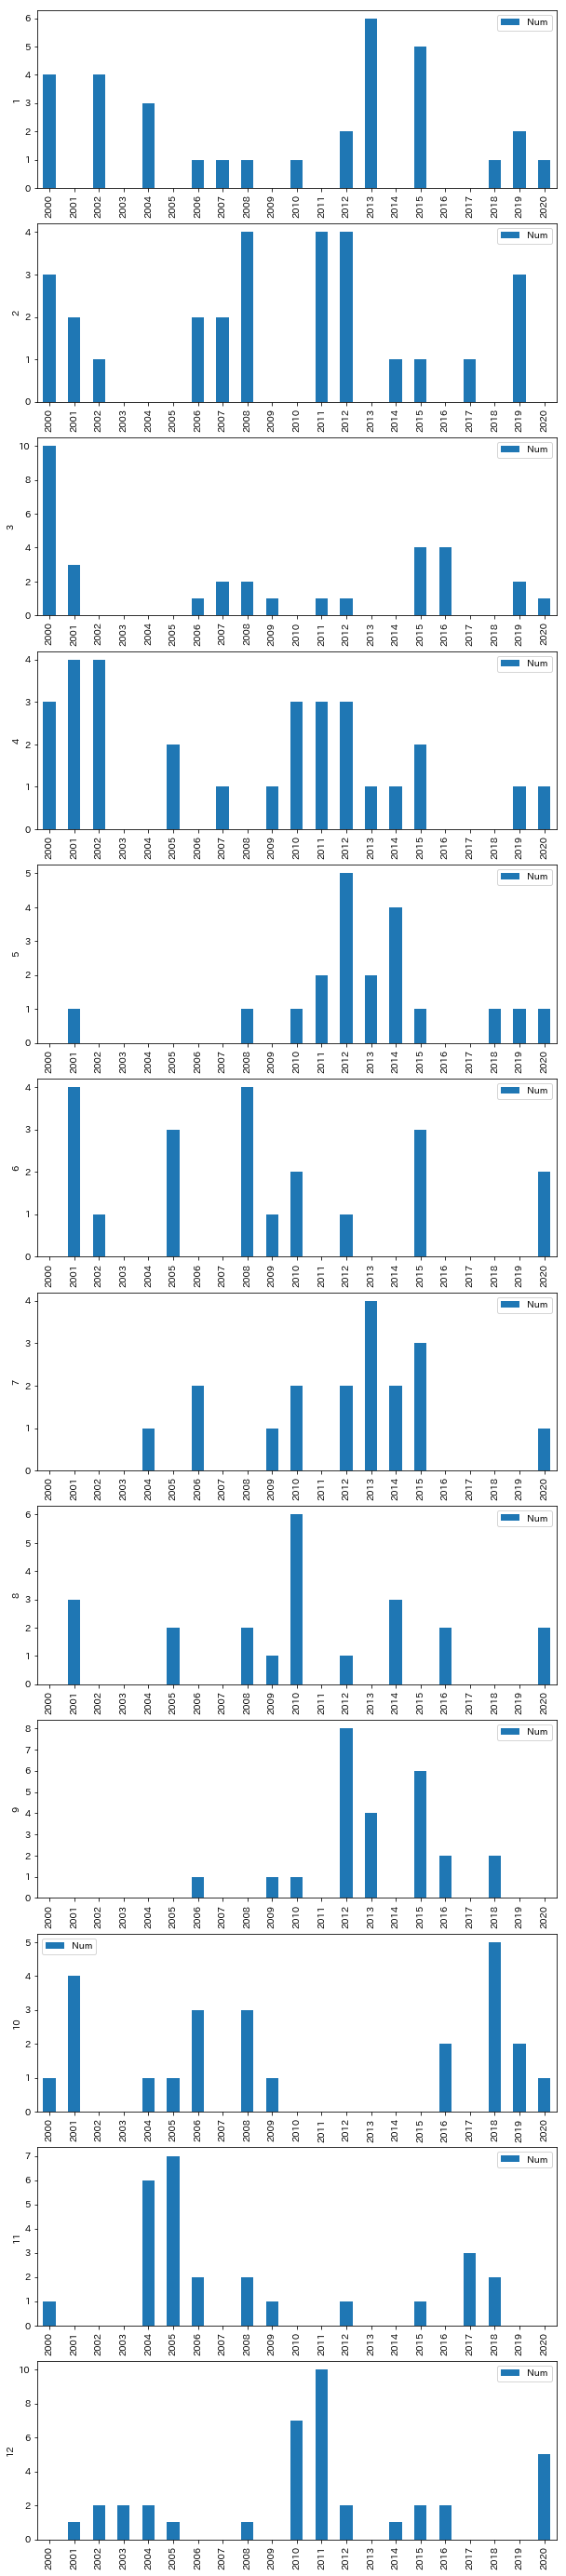

In [20]:
# 棒グラフで各月ごとに表示
# 表示は12-31になっているが、日付をresampleしているので、その年全体を表している。
fig,ax = plt.subplots(12,1,figsize=(10,50))

for i in range(0,12):
    month = i + 1
    s = abnorm_set_hash[month]
    s.plot(kind="bar",ax = ax[i])
    ax[i].set_xticklabels(data_period)
    ax[i].set(ylabel=str(month))
    ax[i].get_yaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [21]:
# 閾値を超えた異常度の数(共通)
def make_abnorm_count_common(abnorm_set_hash, month_list):
    abnorm_count_tmp = None
    for month in month_list:
        if abnorm_count_tmp is None:
            abnorm_count_tmp = abnorm_set_hash[month]
        else:
            abnorm_count_tmp = pd.concat([abnorm_count_tmp,abnorm_set_hash[month]], axis=1)
    abnorm_count_tmp.fillna(0,inplace=True)
    abnorm_count_tmp = abnorm_count_tmp.astype('int64')
    abnorm_count = abnorm_count_tmp.sum(axis=1)
    return abnorm_count

# 年間の閾値を超えた異常度の数
def make_abnorm_count_year(abnorm_set_hash):
    return make_abnorm_count_common(abnorm_set_hash,range(1,13))

# 夏期間(1-3,10-12)の閾値を超えた異常度の数
def make_abnorm_count_summer(abnorm_set_hash):
    return make_abnorm_count_common(abnorm_set_hash,[1,2,3,10,11,12])

# 冬期間(4-9)の閾値を超えた異常度の数
def make_abnorm_count_winter(abnorm_set_hash):
    return make_abnorm_count_common(abnorm_set_hash,range(4,10))

def make_abnorm_count_set(abnorm_set_hash,data_period):
    abnorm_count_set = pd.concat([make_abnorm_count_year(abnorm_set_hash),make_abnorm_count_summer(abnorm_set_hash),make_abnorm_count_winter(abnorm_set_hash)],axis=1)
    abnorm_count_set.columns = ["年間","夏季","冬季"]
    abnorm_count_set.index = data_period
    return abnorm_count_set

abnorm_count_set = make_abnorm_count_set(abnorm_set_hash, data_period)
abnorm_count_set

,年間,夏季,冬季
2000,22,19,3
2001,22,10,12
2002,12,7,5
2003,2,2,0
2004,13,12,1
2005,16,9,7
2006,12,9,3
2007,6,5,1
2008,20,13,7
2009,8,3,5


上記により、平均気温は2012,2015,2000,2001年の異常度が高い

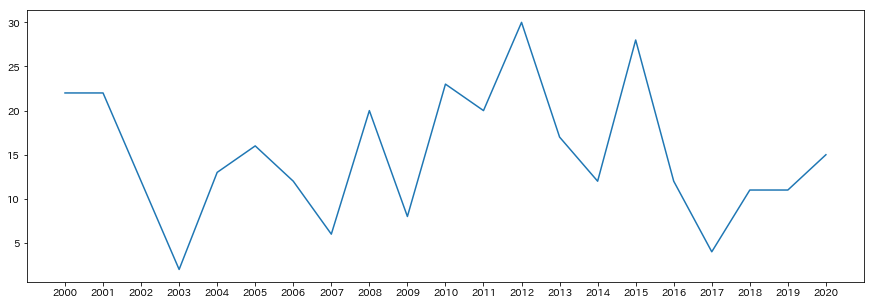

In [22]:
# 年ごとのグラフ
y = abnorm_count_set['年間']
x =abnorm_count_set.index
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

start, end = ax.get_xlim()
stepsize=1
ax.xaxis.set_ticks(pd.np.arange(data_period[0], data_period[-1] + 1, stepsize))

ax.plot(x,y)
plt.show()

In [23]:
abnorm_set_hash[4].head()

,Num
2000-12-31,3
2001-12-31,4
2002-12-31,4
2003-12-31,0
2004-12-31,0


シーズン単位に分けて異常度で閾値を超えた数を数えておく。
（冬季：4-9月, 夏季: 10-3月）

In [24]:
def make_abnorm_winter(abnorm_set_hash, data_period):
    list = [4, 5, 6, 7, 8, 9]
    winter_year = np.array([])
    winter_year = abnorm_set_hash[list[0]]["Num"].copy()
    
    for month in list[1:]:
        winter_year = pd.concat([winter_year, abnorm_set_hash[month]["Num"]], axis = 1)
    winter = winter_year.sum(axis=1)
        
    return winter


def make_abnorm_summer(abnorm_set_hash, data_period):
    list0 = [10, 11, 12]
    list1 = [1, 2, 3]
    
    summer_year = abnorm_set_hash[list0[0]]["Num"].copy()
    
    for month in list0[1:]:
        summer_year = pd.concat([summer_year, abnorm_set_hash[month]["Num"]], axis = 1)
    
    # 年跨ぎにする。
    for month in list1:
        tmp = abnorm_set_hash[month]["Num"].copy()
        tmp = tmp.shift(periods = -1, fill_value=0)
        
        summer_year = pd.concat([summer_year, tmp], axis = 1)

        
    summer = summer_year.sum(axis=1)
    return summer
        

def make_abnorm_year(abnorm_set_hash, data_period):
    summer = make_abnorm_summer(abnorm_set_hash, data_period)
    winter = make_abnorm_winter(abnorm_set_hash, data_period)
    tmp = abnorm_set_hash[1]
    for month in range(2, 13):
        tmp = pd.concat([tmp, abnorm_set_hash[month]], axis=1)
    tmp = tmp.sum(axis=1)
    
    abnorm_year = pd.concat([tmp, summer, winter], axis=1)
    abnorm_year.columns = ["年間","夏季","冬季"]
    abnorm_year.index = data_period
    
    return abnorm_year

abnorm_year= make_abnorm_year(abnorm_set_hash, data_period)
abnorm_year

,年間,夏季,冬季
2000,22,7,3
2001,22,10,12
2002,12,2,5
2003,2,5,0
2004,13,9,1
2005,16,13,7
2006,12,10,3
2007,6,7,1
2008,20,7,7
2009,8,3,5


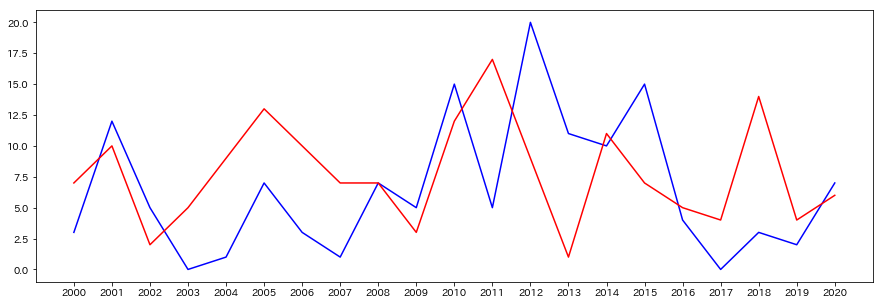

In [25]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

start, end = ax.get_xlim()
stepsize=1
ax.xaxis.set_ticks(pd.np.arange(data_period[0], data_period[-1] + 1, stepsize))

y1 = abnorm_year['冬季']
x1 = abnorm_year.index
ax.plot(x1,y1,color="blue", label="winter")

y2 = abnorm_year['夏季']
x2 = abnorm_year.index
ax.plot(x2,y2,color="red",label="summer")


plt.show()

# 木モデルでの解析

In [26]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [27]:
std = StandardScaler()
isoforest_abnorm_df  = {}
for month in range(1,13):
    X_train = std.fit_transform(month_set_hash[month].drop('日付',axis=1))
    clf = IsolationForest(random_state=1234)
    clf.fit(X_train)
    # X_trainの各点に対する異常度
    #isoforest_abnorm_list =  -1 * clf.decision_function(X_train)

    # 予測
    isoforest_abnorm_list = clf.predict(X_train)
    
    # 日付を元に戻す
    isoforest_abnorm_df[month] = pd.concat([month_set_hash[month]['日付'],pd.Series(isoforest_abnorm_list)],axis=1)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensem

predictで予測

In [28]:
# 各年ごとの月ごとの異常(-1)と予測されたの個数の集計
isoforest_abnorm_df_count = None
for month in range(1,13):
    df_count_month_tmp = None
    for year in data_period:
        df_tmp = isoforest_abnorm_df[month][(isoforest_abnorm_df[month]['日付'] >= dt.datetime(year,month,1)) & (isoforest_abnorm_df[month]['日付'] <=dt.datetime(year,month,calendar.monthrange(year, month)[1]))]
        # predictで-1とでた場合、異常なので、その数を数える。
        df_count_tmp = pd.Series((df_tmp[0] < 0).sum())
        if df_count_month_tmp is None:
            df_count_month_tmp = df_count_tmp
        else:
            df_count_month_tmp = pd.concat([df_count_month_tmp,df_count_tmp],axis = 0)
    if isoforest_abnorm_df_count is None:
        isoforest_abnorm_df_count = df_count_month_tmp
    else:
        isoforest_abnorm_df_count = pd.concat([isoforest_abnorm_df_count,df_count_month_tmp],axis=1)
isoforest_abnorm_df_count.index = data_period
isoforest_abnorm_df_count.columns = range(1,13)

In [29]:
# 各年の月ごとの異常(-1)と予測された数
isoforest_abnorm_df_count

,1,2,3,4,5,6,7,8,9,10,11,12
2000,18,10,20,15,13,3,2,2,4,1,2,0
2001,0,2,1,3,2,4,1,4,1,5,2,4
2002,1,4,2,4,4,1,1,0,4,3,0,2
2003,0,0,4,2,0,1,6,1,3,0,0,2
2004,3,3,2,1,2,3,2,1,0,4,3,1
2005,0,1,1,1,2,4,2,5,5,2,5,4
2006,3,2,0,1,4,4,3,7,1,5,2,0
2007,1,0,3,2,1,4,6,1,0,1,2,1
2008,0,4,2,6,0,5,3,1,2,0,4,5
2009,4,3,5,1,4,7,8,2,6,0,1,2


In [30]:
# 年ごとの数
isoforest_abnorm_df_count_sum = isoforest_abnorm_df_count.sum(axis=1)
isoforest_abnorm_df_count_sum

2000    90
2001    29
2002    26
2003    19
2004    25
2005    32
2006    32
2007    22
2008    32
2009    43
2010    45
2011    49
2012    43
2013    28
2014    26
2015    50
2016    47
2017    41
2018    29
2019    28
2020    31
dtype: int64

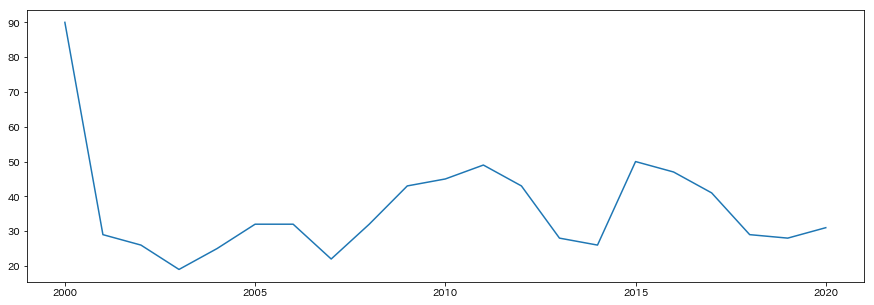

In [31]:
# 年ごとのグラフ
y = isoforest_abnorm_df_count_sum
x =isoforest_abnorm_df_count_sum.index

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

start, end = ax.get_xlim()
stepsize=5
ax.xaxis.set_ticks(pd.np.arange(data_period[0], data_period[-1] + 1, stepsize))


ax.plot(x,y)
plt.show()

[考察]

上記では2000年（特に1-5月）が特に顕著となっている。

また、それを除くと、2010-2012,2015年あたりの異常の数が多い。

# 時系列データとしての解析
年ごとのデータの動きをグラフ化する。

In [32]:
def get_data_timeline(data_hash, data_period):
    
    data_year = {}
    for year in data_period:
        data_year[year] = None
        for i in range(0,12):
            month = i + 1
            if data_year[year] is None:
                data_year[year] = data_hash[year][month]
            else:
                data_year[year] = pd.concat([data_year[year], data_hash[year][month]],axis=0)

    data_all = None
    for year in data_period:
        if data_all is None:
            data_all = data_year[year]
        else:
            data_all = pd.concat([data_all, data_year[year]],axis=0)
    data_all = data_all.reset_index()
    return data_all, data_year

data_all, data_year = get_data_timeline(data_hash, data_period)

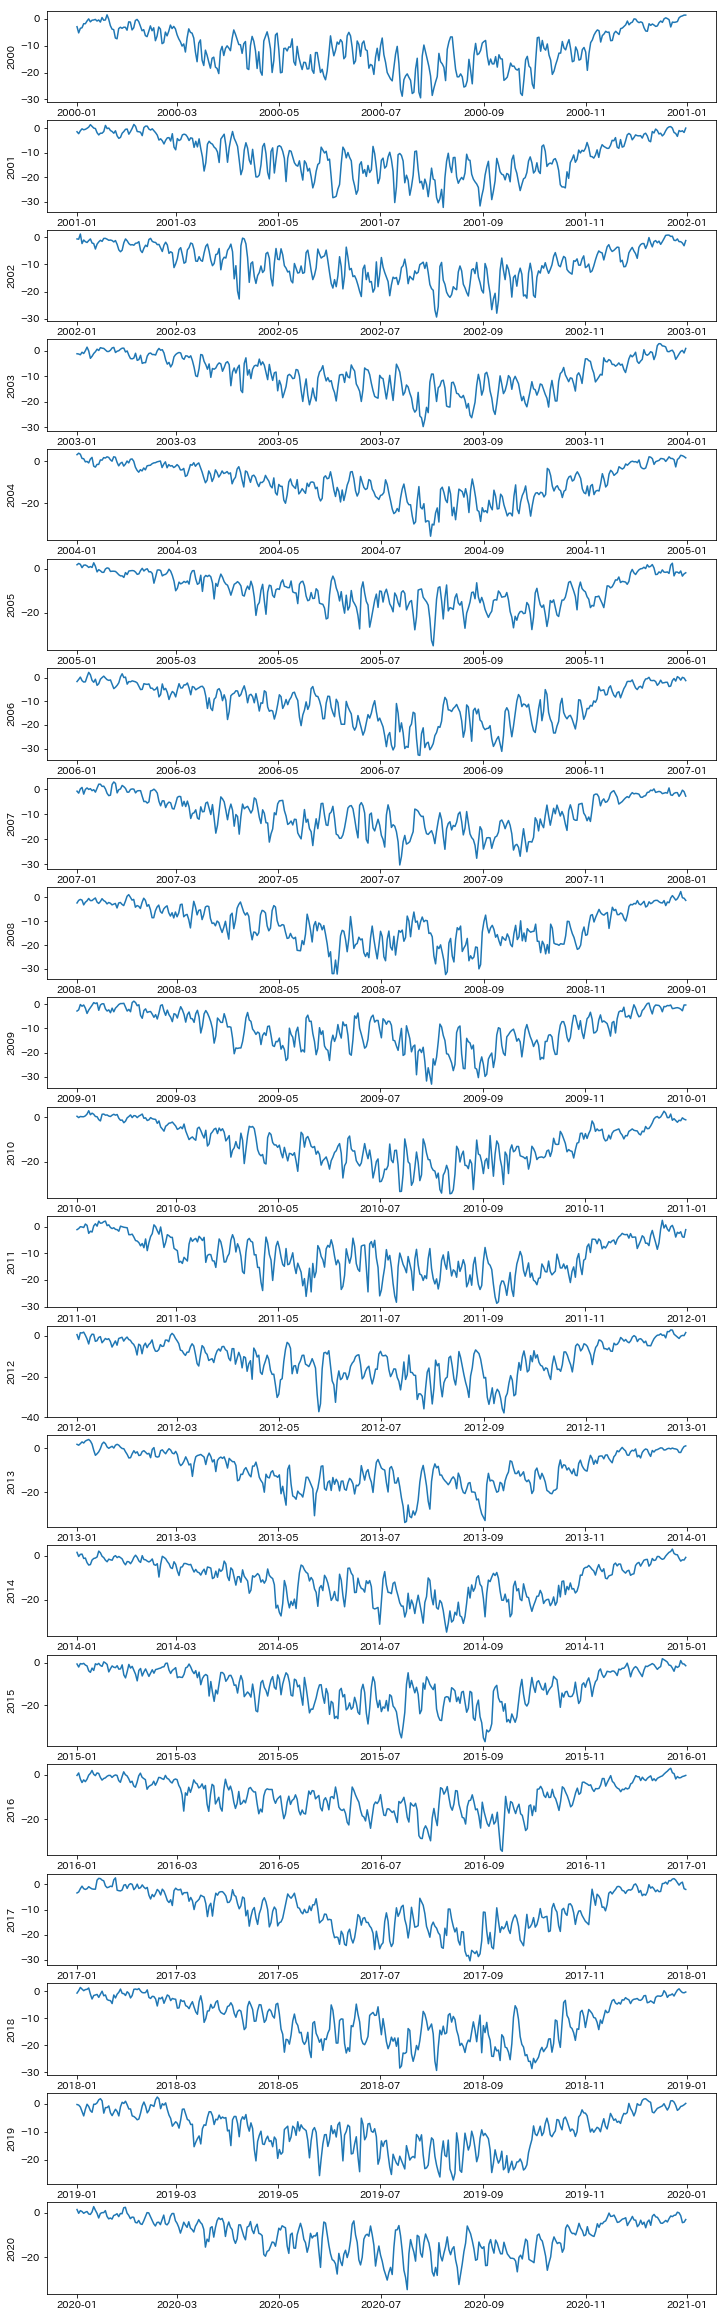

In [33]:
# 年ごとの増減のグラフ

data_period_len = len(data_period)
fig = plt.figure(figsize=(12,data_period_len * 2))

# 日付ラベルフォーマットを修正
#dayｓ = mdates.DayLocator() 
#daysFmt = mdates.DateFormatter('%m-%d')
ax = []
for i, year in enumerate(data_period):
    x = data_year[year]['日付']
    y = data_year[year][target]
    ax.append(fig.add_subplot(data_period_len, 1, i + 1))
    ax[i].plot(x,y)
    ax[i].set_ylabel(year)
    #ax[i].xaxis.set_major_locator(days)
    #ax[i].xaxis.set_major_formatter(daysFmt)
plt.show()

## 全年の時系列データ

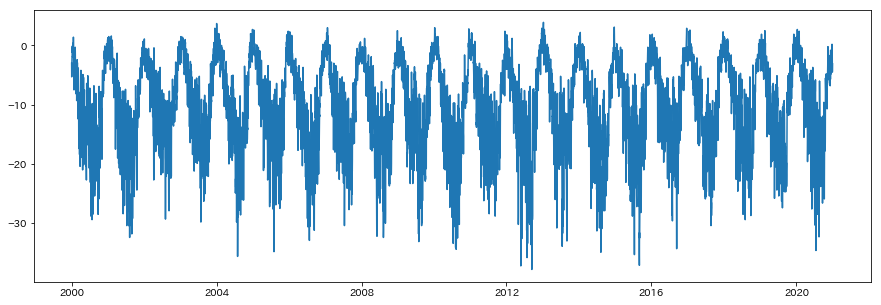

In [34]:
fig = plt.figure(figsize=(15,5))

# 日付ラベルフォーマットを修正
#dayｓ = mdates.DayLocator() 
#daysFmt = mdates.DateFormatter('%m-%d')
x = df_tpl['日付']
y = df_tpl[target]
ax = fig.add_subplot(1, 1, 1)
ax.plot(x,y)
#ax.xaxis.set_major_locator(days)
#ax.xaxis.set_major_formatter(daysFmt)
plt.show()

## ARモデル作成

In [35]:

'''
# AICでモデルの次数を選択
maxlag = ar.select_order(maxlag=40,ic='aic')
print(maxlag) 
'''

'''
# BICの場合
maxlag_b = ar.select_order(maxlag=40,ic='bic')
print(maxlag_b)
'''

# 上記のAICで出した値を参考に決定している。
maxlag = 39

In [36]:
ar = sm.tsa.AR(y)
model_ar = ar.fit(maxlag=maxlag,method='cmle')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### ARモデルによる予測

In [37]:
y_pred = ar.predict(model_ar.params)

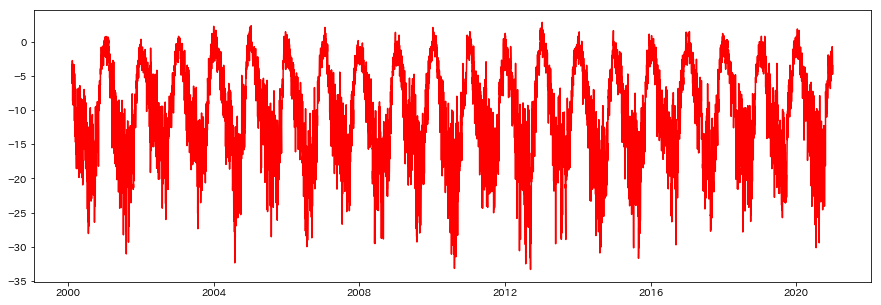

In [38]:
x = data_all['日付'][maxlag:]
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(x,y_pred,"r")
plt.show()

### 誤差（異常度）の算出

In [39]:
def get_timeline_ascore(y, y_pred, maxlag, target):
    y_input = y[maxlag:].reset_index()


    df = pd.DataFrame(y_input[target].to_numpy(), columns={"y"})
    df["y_pred"] = y_pred
    #df["error"] = (df["y"] - df["y_pred"])**2 #　誤差の2乗

    # 異常度を算出する
    y_train = y_input[target].to_numpy()
    error = y_train - y_pred
    std = error.std()

    #pdf = scipy.stats.norm.pdf(error, loc=0, scale=std)
    #df["score"] = -1* np.log(pdf)

    df["score"] = (error**2)/(std**2)
    return df

df_timeline_ascore = get_timeline_ascore(y, y_pred, maxlag, target) 

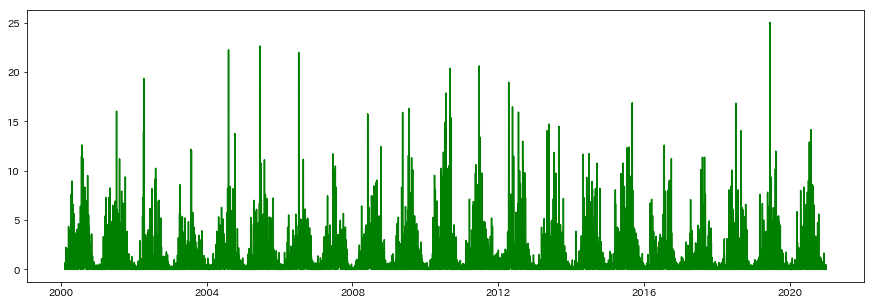

In [40]:
# グラフ
x = data_all['日付'][maxlag:]
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(x,df_timeline_ascore["score"],"g")
plt.show()

### 日付を一体化して、誤差の大きい上位の日付を並べる。

In [41]:
df_pred = pd.concat([df_timeline_ascore,data_all['日付']],axis=1)

# 上位
df_pred.sort_values(by='score',ascending=False).head(10)

,y,y_pred,score,日付
7071,-5.1,-21.317814,25.021558,2019-05-12
1958,-9.1,-24.523065,22.629298,2005-05-12
1640,-13.4,-28.688218,22.235323,2004-06-28
2344,-10.9,-26.097568,21.972420,2006-06-02
4154,-6.5,-21.217929,20.607397,2011-05-17
3861,-8.2,-22.833929,20.372841,2010-07-28
790,-3.2,-17.459484,19.343603,2002-03-01
4450,-6.0,-20.115664,18.955374,2012-03-08
3821,-9.7,-23.401557,17.859510,2010-06-18
5689,-13.4,-26.720898,16.880943,2015-07-30


冬季期間(4-9月)は誤差が出やすいと考えられる。

### 異常度からホテリングT^2を適用してみる。

In [42]:
# 閾値を5%にする場合
# 異常度が閾値a_th以上になったら、それは5%の確率でしかおこらない珍しいことであるため、異常に違いないと判断する
a_th = stats.chi2.ppf(0.95, df=1)
a_th

3.841458820694124

In [43]:
def get_df_timeline_abnorm_year(df_pred, a_th):
    # 閾値を超えたもののみを取得

    df_abnorm = df_pred[df_pred["score"] > a_th]


    # 月毎に数を集計
    df_abnorm_month = df_abnorm.resample('M',on="日付").count()

    # 日付のみ残す
    df_abnorm_month = df_abnorm_month.drop(['y', 'y_pred', 'score'], axis=1)
    # 日付を年間に変更
    df_abnorm_month = df_abnorm_month.rename(columns={'日付': '月間'})

    # 年ごとに数を集計
    df_abnorm_year = df_abnorm.resample('Y',on="日付").count()

    # 日付のみ残す
    df_abnorm_year = df_abnorm_year.drop(['y', 'y_pred', 'score'], axis=1)
    # 日付を年間に変更
    df_abnorm_year = df_abnorm_year.rename(columns={'日付': '年間'})

    df_abnorm_year['year'] = data_period

    # indexを年のみにする
    df_abnorm_year = df_abnorm_year.set_index('year')
    
    return df_abnorm_year, df_abnorm_month

df_abnorm_year, df_abnorm_month = get_df_timeline_abnorm_year(df_pred, a_th)

df_abnorm_year.sort_values(by='年間',ascending=False).head(5)

,年間
year,
2012,40
2015,33
2001,31
2011,30
2014,29


2012,2015,2001年あたりで異常度が多いのは、1次元の正規分布としての異常度の算出した場合と一致する。

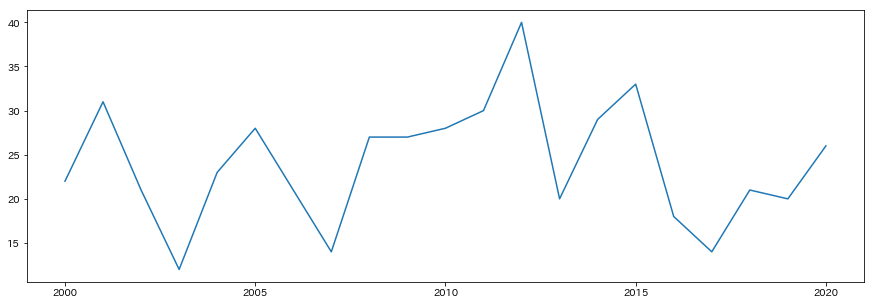

In [44]:
# 年ごとのグラフ
y = df_abnorm_year['年間']
x =df_abnorm_year.index

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

start, end = ax.get_xlim()
stepsize=5
ax.xaxis.set_ticks(pd.np.arange(data_period[0], data_period[-1] + 1, stepsize))


ax.plot(x,y)
plt.show()

### 夏と冬で異常度を分ける。
冬季が高くなる傾向があるので、4-9月(冬季), 10-3月(夏季）で分けてみる。

（年をまたぐので、最後の年は夏季は12月まで）

In [45]:
winter_year = np.array([])
summer_year = np.array([])
for year in data_period:
    winter = np.int64(df_abnorm_month[(df_abnorm_month.index >= dt.datetime(year,4,1)) & (df_abnorm_month.index <= dt.datetime(year,10,31))].sum()['月間'])
    winter_year = np.append(winter_year, winter)
    summer = np.int64(df_abnorm_month[(df_abnorm_month.index >= dt.datetime(year,10,1)) & (df_abnorm_month.index <= dt.datetime(year+1,3,31))].sum()['月間'])
    summer_year = np.append(summer_year, summer)

In [46]:
df_abnorm_year['冬季'] = winter_year
df_abnorm_year['夏季'] = summer_year

In [47]:
df_abnorm_year.head()

,年間,冬季,夏季
year,,,
2000,22,15.0,8.0
2001,31,23.0,5.0
2002,21,16.0,4.0
2003,12,8.0,4.0
2004,23,20.0,5.0


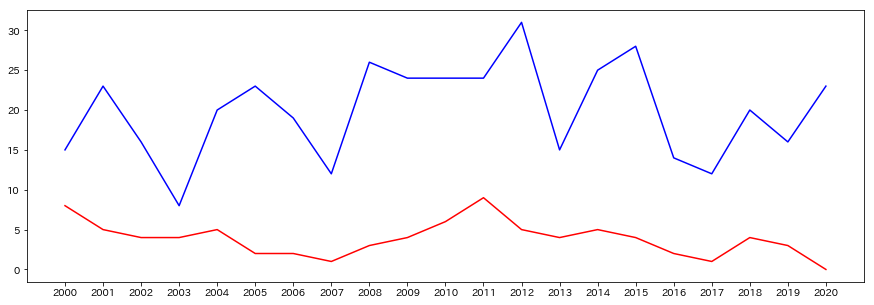

In [48]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

start, end = ax.get_xlim()
stepsize=1
ax.xaxis.set_ticks(pd.np.arange(data_period[0], data_period[-1] + 1, stepsize))

y1 = df_abnorm_year['冬季']
x1 =df_abnorm_year.index
ax.plot(x1,y1,color="blue", label="winter")

y2 = df_abnorm_year['夏季']
x2 =df_abnorm_year.index
ax.plot(x2,y2,color="red",label="summer")


plt.show()

# ガウス型グラフィカルラッソ
一つの変数ではなく、全変数に対してガウス型グラフィカルラッソにより異常度を調べてみる。

異常度の算出は以下

$\displaystyle a_i \equiv -\ln p ({x'}_i | \mathbf{x'}_{-i},\mathcal{D}) = \frac{1}{2}\ln \frac{2\pi}{\Lambda_{i,i}} + \frac{1}{2\Lambda_{i,i}}(\sum_{j=1}^M \Lambda_{i,j}{x'}_j)^2$

In [49]:
# 外れ値検出問題としての異常度算出
import math

def make_graph_score(df_norm, prec):
    df_scores = pd.DataFrame(columns=df_norm.columns)

    for t in df_norm.index:
        row = []
        for i in range(df_norm.shape[1]):
            acc = 0
            for j in range(df_norm.shape[1]):
                if not math.isnan(df_norm[j ][t]):
                    acc += prec[i][j] * df_norm[j ][t]
            acc = acc**2
            score = 0.5 * math.log(2*math.pi/prec[i][i]) + 0.5 / prec[i][i] * acc
            row.append(score)
        df_scores.loc[t] = row
    return df_scores

閾値を決めて正常異常を判定したいので、
ホテリングT2法に従い、異常度の算出を以下と仮定する場合は以下

$\displaystyle a_i \equiv \frac{1}{\Lambda_{i,i}}(\sum_{j=1}^M \Lambda_{i,j}{x'}_j)^2$

In [50]:
# ホテリングT2法に従い、第一項を無視し、２をかけた形式に直してみる。
import math

def make_graph_score_ht2(df_norm, prec):
    df_scores = pd.DataFrame(columns=df_norm.columns)

    for t in df_norm.index:
        row = []
        for i in range(df_norm.shape[1]):
            acc = 0
            for j in range(df_norm.shape[1]):
                if not math.isnan(df_norm[j ][t]):
                    acc += prec[i][j] * df_norm[j ][t]
            acc = acc**2
            score = 1 / prec[i][i] * acc
            row.append(score)
        df_scores.loc[t] = row

    return df_scores

上記は各変数を個別に求める式であるが、
各変数の異常度を一度に求める場合は、以下のような式になる。 
 
 $\boldsymbol{a} \equiv \frac{1}{2} \ln \frac{2\pi}{(\Lambda_{1,1},\Lambda_{2,2},\dots,\Lambda_{M,M})} + \frac{1}{2(\Lambda_{1,1},\Lambda_{2,2},\dots,\Lambda_{M,M})}(\boldsymbol{X'} \cdot \Lambda^T)^2$
 
 ホテリングT2法では以下となる。
  
  $\boldsymbol{a} \equiv \frac{1}{2(\Lambda_{1,1},\Lambda_{2,2},\dots,\Lambda_{M,M})}(\boldsymbol{X'} \cdot \Lambda^T)^2$
  
 よってnumpyでの行列計算を行う形式にする。

In [51]:
# ガウス型グラフィカルモデルの外れ値検出におけるスコア算出（通常、ホテリングT^2両対応）
import numpy as np
from enum import Enum, auto

# 異常度の選択の列挙型
class GaussianGraphAbnormScoreType(Enum):
    NORMAL = auto() # 通常の算出
    HT2 = auto() # ホテリングT^2法

#　numpyデータに対しての異常度の算出
# Xの列数とprecの列数は一致する必要がある。
def get_gaussian_graph_abnorm_score(X, prec,  score_type=GaussianGraphAbnormScoreType.HT2):
    get_score_select = {
        # ホテリングT^2による異常度(第一項を無視し、２をかけた形式)
        # Sum部分は行列内積で代用
        GaussianGraphAbnormScoreType.HT2 :
            lambda X, prec : (1/np.diag(prec)) * (np.dot(np.nan_to_num(X), prec.T) ** 2),
        # 通常の異常度 (後半部分はホテリングT^2の計算を利用)
        GaussianGraphAbnormScoreType.NORMAL:
            lambda X, prec : (0.5 * np.log(2 * np.pi / np.diag(prec))) + (0.5 * get_score_select[GaussianGraphAbnormScoreType.HT2](X, prec))
    }
    return get_score_select[score_type](X, prec)

# データフレームに対しての異常度
def get_gaussian_graph_abnorm_score_df(df, prec, score_type=GaussianGraphAbnormScoreType.HT2):
    np_tmp = get_gaussian_graph_abnorm_score(df, prec, score_type)
    df_scores = pd.DataFrame(data=np_tmp, index=df.index, columns=df.columns)
    return df_scores

In [52]:
# 閾値設定
a_th = stats.chi2.ppf(0.95, df=1)
a_th

3.841458820694124

### 月毎でグラフィカルラッソの計算

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso

std = StandardScaler()
alphas=[0.01, 0.3, 0.6, 0.9, 2.0]

dic_model_month = {}

# 月毎の異常度を算出
for month in range(1,13):
    tmp_month_set_hash =month_set_hash[month]
    tmp_X = std.fit_transform(tmp_month_set_hash.drop('日付',axis=1))
    tmp_dic_model = {}
    for alpha in alphas:
        #print(alpha)
        gl = GraphicalLasso(alpha=alpha, max_iter=50).fit(tmp_X)
        tmp_dic_model[alpha] = gl
    dic_model_month[month] = tmp_dic_model

/opt/conda/lib/python3.7/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: -2.111e-02
  % (max_iter, d_gap), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: -4.404e-02
  % (max_iter, d_gap), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 7.407e-02
  % (max_iter, d_gap), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: -2.878e-03
  % (max_iter, d_gap), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge 

alpha=0.01
alpha=0.3
alpha=0.6
alpha=0.9
alpha=2.0


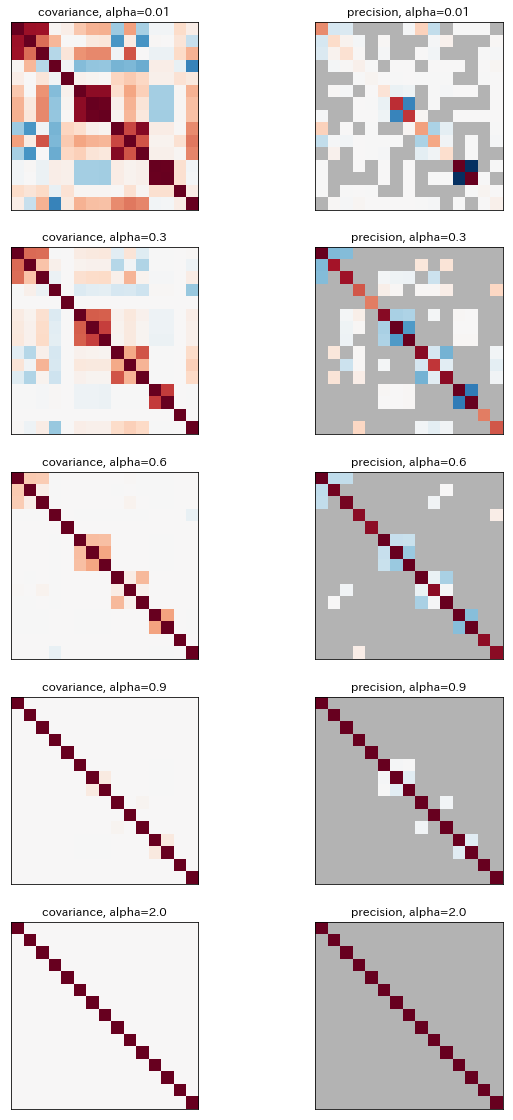

In [54]:
plt.figure(figsize=(10, 20))

month = 1 # 例: 1月

for i, alpha in enumerate(alphas):
    print("alpha=%s"%alpha)
    gl = dic_model_month[month][alpha]
    cov_ = gl.covariance_
    prec_ = gl.precision_
    
    # 分散共分散行列をプロット
    vmax = cov_.max()
    plt.subplot(5, 2, i*2+1)
    plt.imshow(cov_, interpolation='nearest', vmin=-vmax, vmax=vmax,
                       cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('covariance, alpha=%s'%alpha)


    # 精度行列をプロット
    vmax = .9 * prec_.max()
    ax = plt.subplot(5, 2, i*2+2)
    plt.imshow(np.ma.masked_equal(prec_, 0),
               interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('precision, alpha=%s'%alpha)
    if hasattr(ax, 'set_facecolor'):
        ax.set_facecolor('.7')
    else:
        ax.set_axis_bgcolor('.7')

plt.show()

In [55]:
alpha = 0.6

### 月毎の各変数の異常度を求め閾値を超えた数を数える。

In [56]:
std = StandardScaler()
df_graphical = pd.DataFrame()

for year in data_period:
    # 年のデータ
    tmp_month_set_hash = make_month_set_hash(data_hash,range(year,year+1))
    for month in range(1,13):
        tmp_X = std.fit_transform(tmp_month_set_hash[month].drop('日付',axis=1))
        tmp_df_norm = pd.DataFrame(tmp_X)
        gl = dic_model_month[month][alpha]
        cov_ = gl.covariance_
        prec_ = gl.precision_
        tmp_df_scores2 = get_gaussian_graph_abnorm_score_df(tmp_df_norm, prec_, score_type=GaussianGraphAbnormScoreType.HT2)
        tmp_abnorm_count_list = tmp_df_scores2[tmp_df_scores2 >= a_th].count()
        # 日付を追加
        dt = pd.to_datetime(str(year) + "-" + str(month)).replace(day=calendar.monthrange(year, month)[1])
        tmp = pd.Series(dt)
        tmp = tmp.append(tmp_abnorm_count_list)
        
        tmp_abnorm_count_df = pd.DataFrame(tmp).T
        df_graphical = pd.concat([df_graphical, tmp_abnorm_count_df], axis=0)


df_graphical.columns = columns
df_graphical.reset_index(inplace=True)

df_graphical = df_graphical.drop('index',axis=1)

In [57]:
df_graphical.head()

,日付,平均気温,最高気温,最低気温,合計全天日照量,最深積雪,平均風速,最大風速,最大瞬間風速,平均湿度,平均蒸気圧,最小相対湿度,平均現地気圧,平均海面気圧,最低海面気圧,平均雲量
0,2000-01-31 00:00:00,0,0,0,1,0,1,0,0,0,3,0,0,0,2,0
1,2000-02-29 00:00:00,0,0,0,0,1,0,0,0,0,0,1,0,0,4,1
2,2000-03-31 00:00:00,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0
3,2000-04-30 00:00:00,0,1,0,3,0,0,0,0,0,0,2,0,0,5,3
4,2000-05-31 00:00:00,0,0,0,2,0,1,0,0,0,0,0,0,0,0,3


In [58]:
# 年ごとに数を集計
df_graphical_year = df_graphical.resample('Y',on="日付").sum()
df_graphical_year.index = data_period

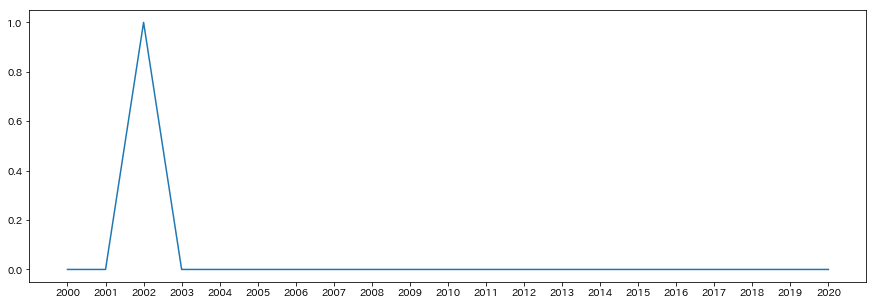

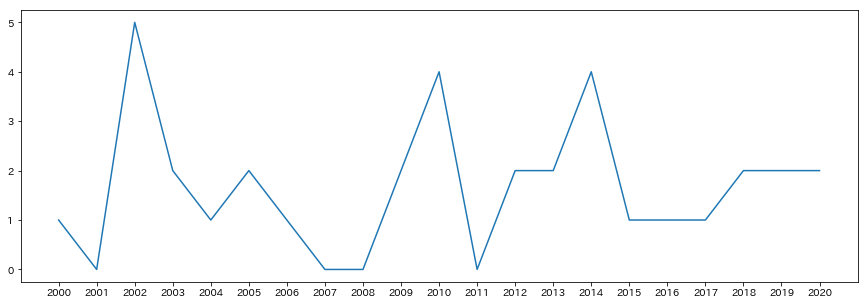

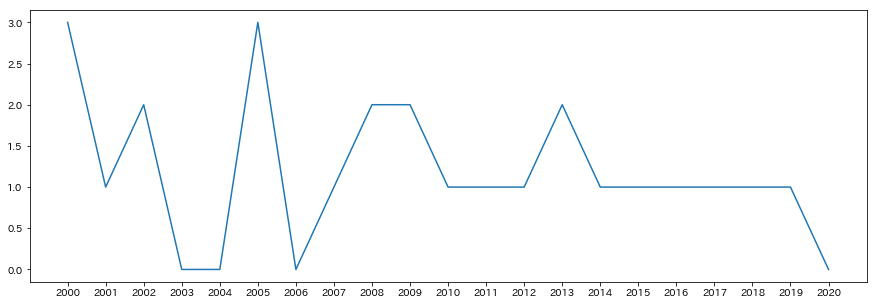

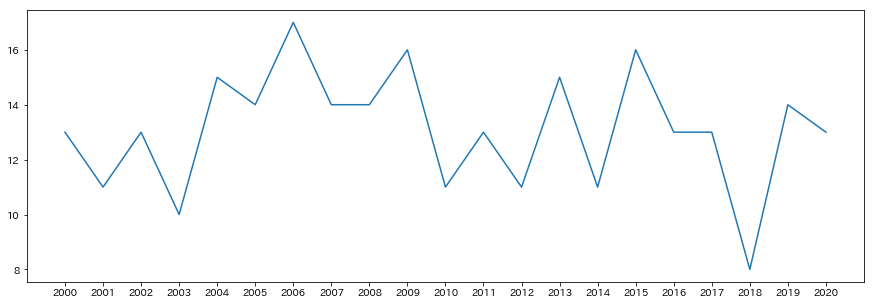

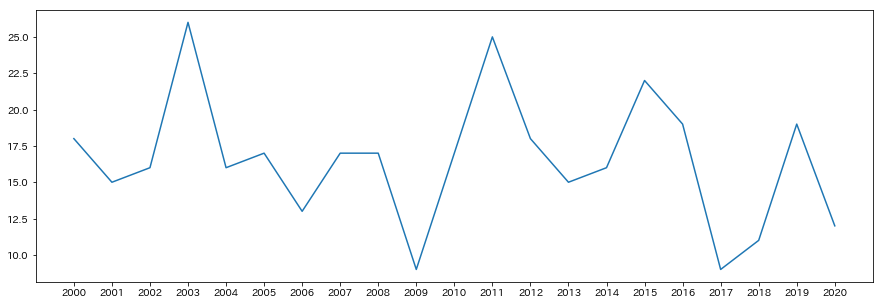

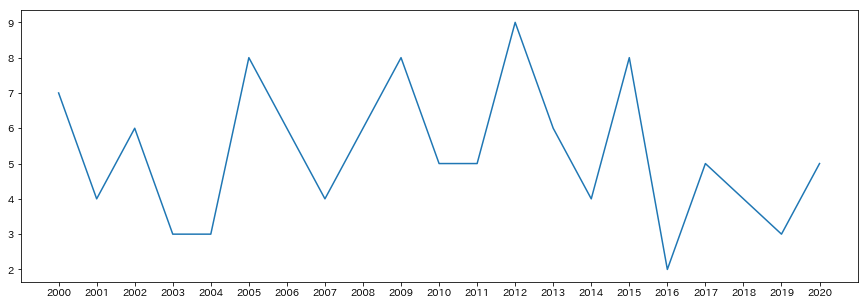

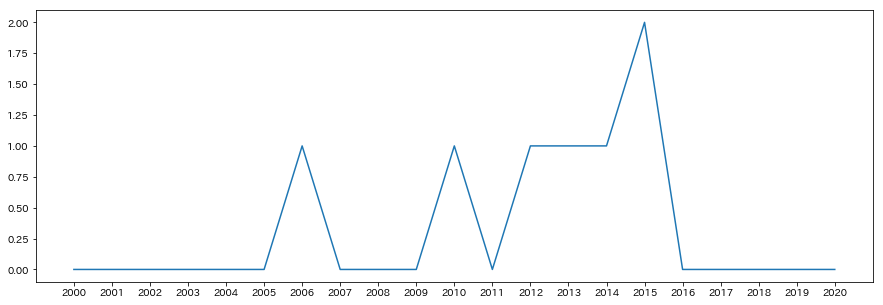

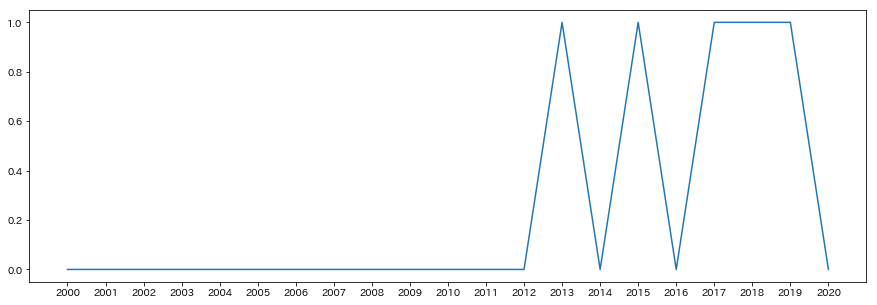

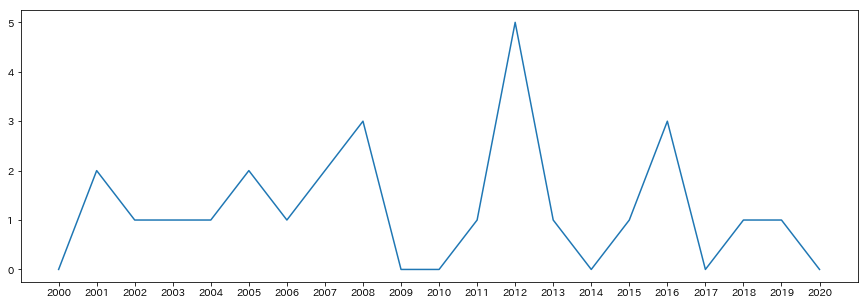

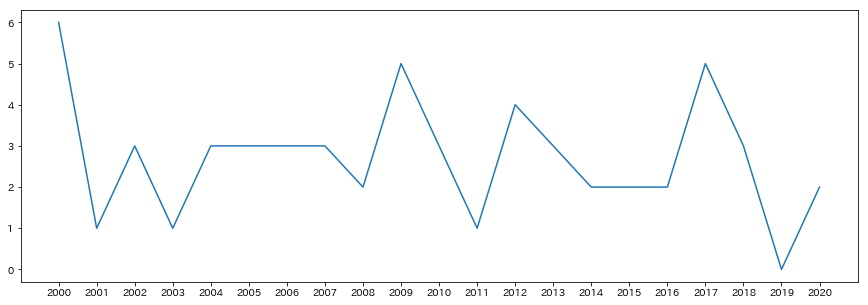

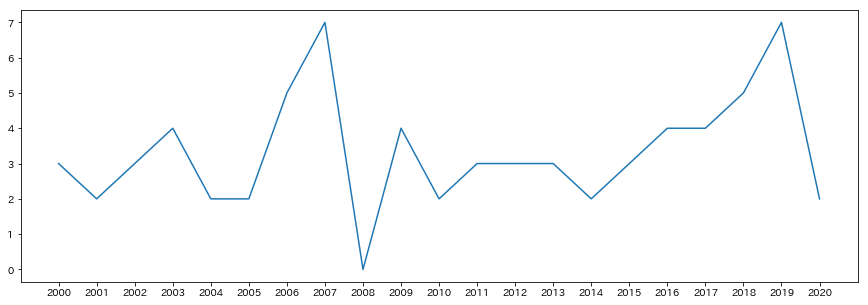

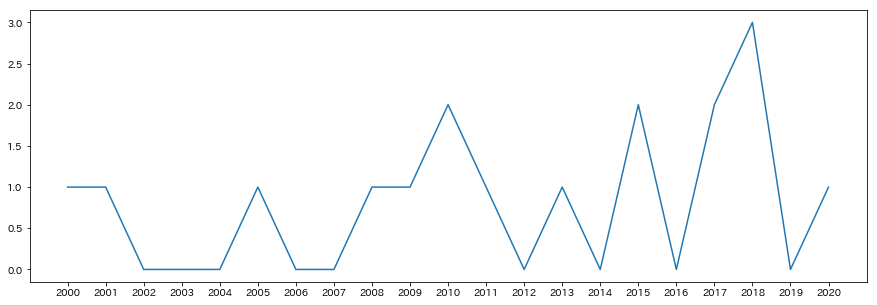

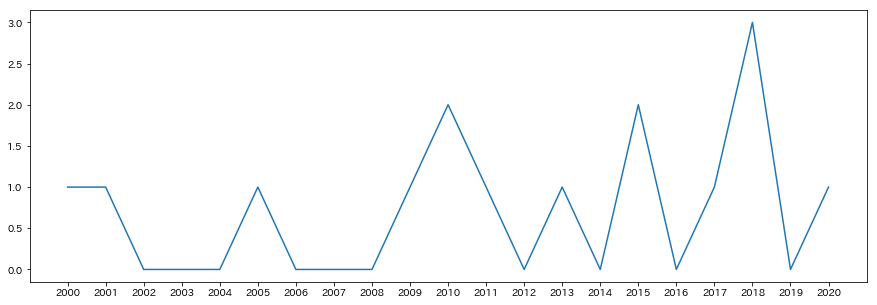

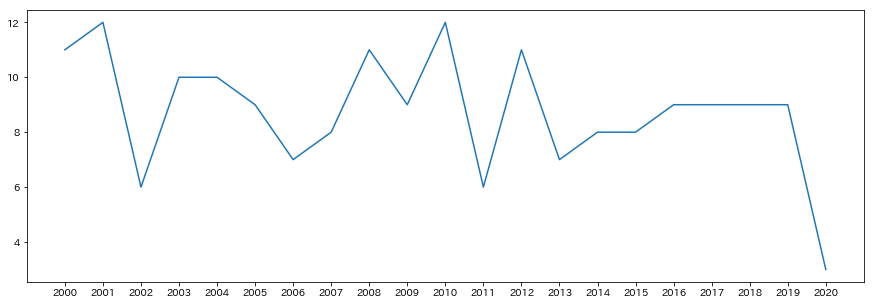

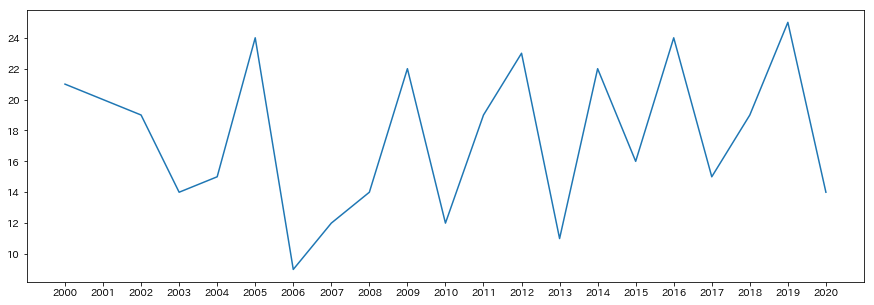

In [59]:
# 　年ごとのグラフ

for col in df_graphical_year.columns[:]:
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    start, end = ax.get_xlim()
    stepsize=1
    ax.xaxis.set_ticks(pd.np.arange(data_period[0], data_period[-1] + 1, stepsize)) 
    y = df_graphical_year[col]
    x = df_graphical_year.index
    ax.plot(x,y)
    plt.show

In [60]:
# 全てのパラメータの年ごとの合計
df_graphical_year_sum = df_graphical_year.sum(axis=1)

<function matplotlib.pyplot.show(*args, **kw)>

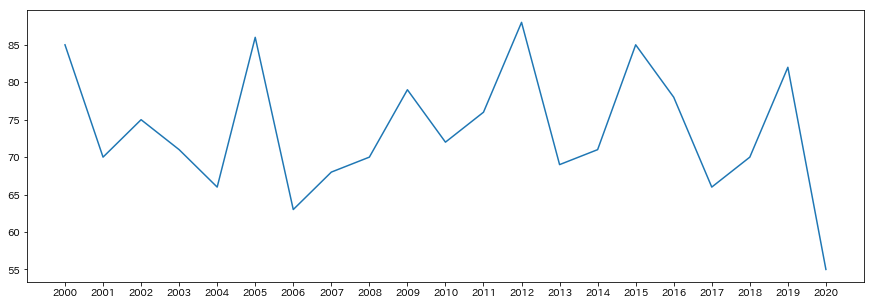

In [61]:
# 　年ごとのグラフ
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)


start, end = ax.get_xlim()
stepsize=1
ax.xaxis.set_ticks(pd.np.arange(data_period[0], data_period[-1] + 1, stepsize))

y = df_graphical_year_sum
x = df_graphical_year_sum.index
ax.plot(x,y)

plt.show

上記においては2000,2005,2012,2015,2019年あたりの異常度が高い。

ただし、上記はalphaの値を変動させることで、大きく変わる。

# 結論


平均気温に関して1次元正規分布、時系列データとして異常度を算出した。

また木モデルで全体のデータとして異常度を算出した。

それぞれの傾向はあるが、2000-2001年,2012-2015年あたりの異常度が高い

また、全体のデータを用いて、ガウス型グラフィカルモデルにおいて異常度を算出した。

しかし、合計で見た場合、alphaの値によって異常度は変わるので、明確にどの年の異常度が高いとは言えない。


# 参考：太陽黒点との比較

データは以下から取得（CSVファイルがあるため） http://www.sidc.be/silso/datafiles

長期の比較をするため、1980-2020年のデータを使用する。（平均気温については、1980年からのデータがあるため。）

In [62]:
import datetime as dt
import calendar

In [63]:
data_period = range(1980,2021)

In [64]:
sunspot_data = pd.read_csv("Data/SN_d_tot_V2.0.csv",sep=';',names=('Year', 'Month', 'Day', 'FracDate','total','std','num','ind'))

# 年で期間以外ののものを削除
sunspot_data = sunspot_data[(sunspot_data['Year'] >= data_period[0])]
sunspot_data = sunspot_data[(sunspot_data['Year'] <= data_period[-1])]

sunspot_data = sunspot_data.reset_index(drop=True)
#　日付を統合し、totalのみ採用

sunspot_data['datetime'] = [pd.Timestamp(
        year=int(row['Year']), month=int(row['Month']), day=int(row['Day']))
    for index, row in sunspot_data.iterrows()]

sunspot_data = sunspot_data.drop(['Year', 'Month', 'Day','FracDate','std','num','ind'], axis=1)

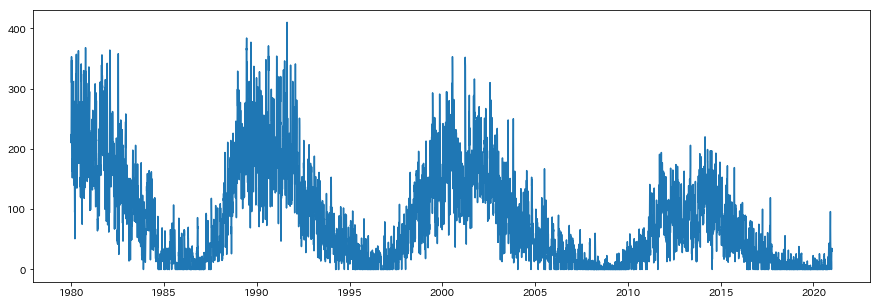

In [65]:
# 日毎のtotal
x = sunspot_data['datetime']
y = sunspot_data['total']
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

ax.plot(x,y)

plt.show()

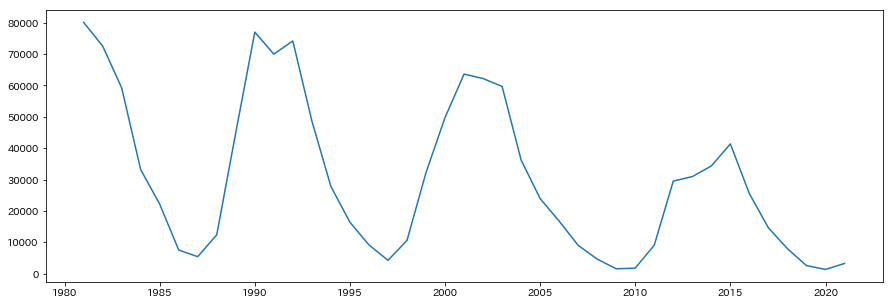

In [66]:
# 年単位でのまとめ直し
sunspot_total = sunspot_data.resample('Y',on="datetime").sum()
x = sunspot_total.index
y = sunspot_total['total']
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

ax.plot(x,y)


plt.show()

太陽黒点の数に関しては周期性があり、約11年周期で増減しているらしい。

1980-2020までの平均気温をデータとして設定する。

## 1次元ガウス分布としての異常度の場合

In [67]:
df = get_data_file(data_period)
df_tpl, columns = make_df_tpl(df)
data_hash = make_data_hash(df_tpl, data_period)
data_tpl_mean_hash = make_data_table_hash(data_hash, data_label, data_period)
month_set_hash = make_month_set_hash(data_hash, data_period)
muhat,sigmahat = get_musigma(month_set_hash, target)
ascore = get_ascore(month_set_hash, muhat, sigmahat, target)
abnorm_set_hash = get_abnorm_set_hash(month_set_hash, ascore, data_period, a_th)
abnorm_count_set = make_abnorm_count_set(abnorm_set_hash, data_period)
abnorm_year= make_abnorm_year(abnorm_set_hash, data_period)

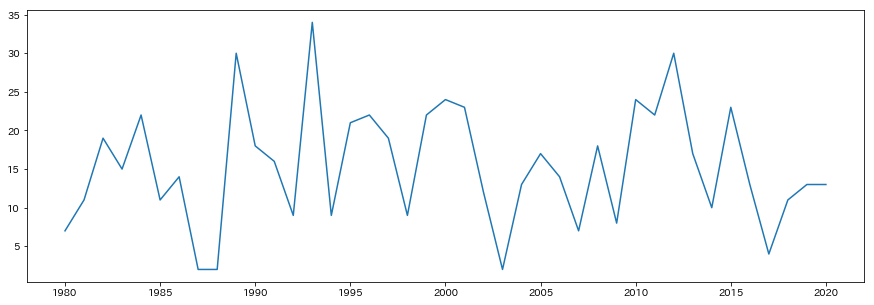

In [68]:
# 年ごとのグラフ
y = abnorm_count_set['年間']
x =abnorm_count_set.index
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(x,y)
plt.show()

## 時系列データとしての異常度の場合

In [69]:
data_all, data_year = get_data_timeline(data_hash, data_period)
y = df_tpl[target]
maxlag = 39
ar = sm.tsa.AR(y)
model_ar = ar.fit(maxlag=maxlag,method='cmle')
y_pred = ar.predict(model_ar.params)
df_timeline_ascore = get_timeline_ascore(y, y_pred, maxlag, target) 
df_pred = pd.concat([df_timeline_ascore,data_all['日付']],axis=1)
df_abnorm_year, df_abnorm_month = get_df_timeline_abnorm_year(df_pred, a_th)

winter_year = np.array([])
summer_year = np.array([])
for year in data_period:
    winter = np.int64(df_abnorm_month[(df_abnorm_month.index >= dt.datetime(year,4,1)) & (df_abnorm_month.index <= dt.datetime(year,10,31))].sum()['月間'])
    winter_year = np.append(winter_year, winter)
    summer = np.int64(df_abnorm_month[(df_abnorm_month.index >= dt.datetime(year,10,1)) & (df_abnorm_month.index <= dt.datetime(year+1,3,31))].sum()['月間'])
    summer_year = np.append(summer_year, summer)
df_abnorm_year['冬季'] = winter_year
df_abnorm_year['夏季'] = summer_year

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


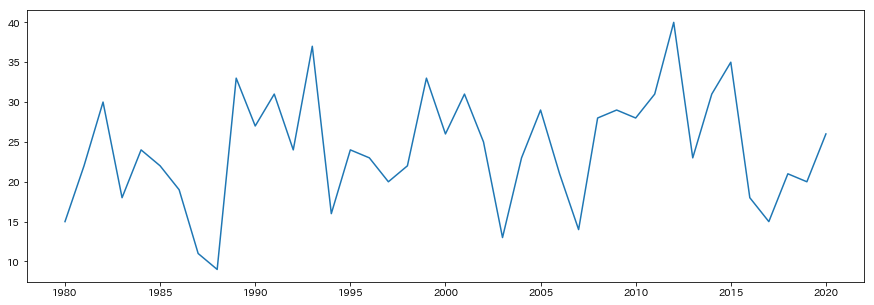

In [70]:
# 年ごとのグラフ
y = df_abnorm_year['年間']
x =df_abnorm_year.index

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

start, end = ax.get_xlim()
stepsize=5
ax.xaxis.set_ticks(pd.np.arange(data_period[0], data_period[-1] + 1, stepsize))


ax.plot(x,y)
plt.show()